Notebook looking to reproduce plots from Ch 3 of Matt Pyle's thesis

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../optimal_filter')
from optimal_filter_utils import *

In [3]:
# trace parameters
N = 16*4096 # no. of samples
T = 6 # sampling half period (s)
idx, tk, wn = get_idx_tk_wn(N = N, T = T)

wspace = np.geomspace(1e2, 2e7, 250)
fn = wspace/2/np.pi

In [4]:
# system parameters

Sigma = 0.32e9 # electron/phonon coupling constant (W/K^5 m^3) (or is it 0.32e-12???)
n_therm = 5 # thermal conduction power law exponent
vtes = 1.7e-14 # TES volume (m^3) (17,000 um^3)
rhow = 1.32e-7 # W film resistivity (Ohm m)
Rn = 700e-3 # normal resistance of single phonon channel (Ohm)
fsc = 2.5 # heat capacity increase due to superconducting/normal phase change
gammaw = 108 # W heat capacity coefficient (J/K^2 m^3)
Tc = 80e-3 # K
dTc90_10 = 0.5e-3 # K
ltes = 220e-9 # TES length in direction of current flow (m)
nchan = 8 # number of phonon channels
Tbath = Tc*0.96 # 0.9?

# electronics params
Rbias = 1.25e3 # Ohm
Tbias = 300 # K
Rfeedback = 1e3 # Ohm
Rs = 20e-3 # Ohm
Ts = 0.6 # K
Rp = 4e-3 # Ohm
Tp = 40e-3 # K
Lsquid = 200e-9 # SQUID inductance + parasitic inductance of wiring and detector (H)

# derived params
alpha = (np.log(9)*Tc/2/dTc90_10) # from fxnal form below
beta = 1.1 # estimated from fig 3.23 from Matt's thesis, Tc = 80 mK
Rl = Rp + Rs
R0 = Rn + Rp + Rs # total resistance
Cw = fsc*gammaw*vtes*Tc # TES total heat capacity (J/K)
Pbath = Sigma*vtes*(Tc**n_therm - Tbath**n_therm) # bath thermal power (W)
G = n_therm*Sigma*vtes*Tc**(n_therm - 1) # dG/dT (W/K)
Tstar = (Rs*Ts + Rp*Tp + Rn*Tc)/R0
Ell = Pbath*alpha/G/Tc
tau_eff = Cw/G/(Ell + 1) # 

# constants 
hbaroverkb = 7.638235233106251e-12 # (Kelvin-sec)
kb = 1.38064852e-23 # J/K

In [5]:
print(f'Pbath = {Pbath*1e12:.5g} pW')

Pbath = 3.2911 pW


In [6]:
G*Ell/Cw

19693.21102203738

In [7]:
alpha, beta

(175.77796618689754, 1.1)

In [8]:
# R(T) curve parameterization (according to Matt seems to get the qualitative job done)

def rho_TES(J, T, rho_n = Rn/vtes, eta = 1):
    thing = (eta/1.76)*np.sqrt(hbaroverkb*Rn*Tc/Cw)*J
    return rho_n*(1 + np.tanh((T - Tc - thing**(2/3))*np.log(9)/dTc90_10))/2

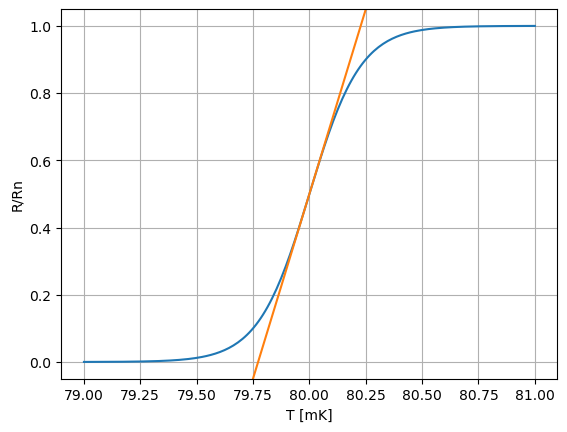

In [9]:
def plot_T():
    Tvals = Tc + 2*dTc90_10*np.linspace(-1, 1, 200)
    rho_vals = vtes*rho_TES(0, Tvals)/Rn

    plt.figure()
    plt.grid()
    plt.plot(Tvals*1e3, rho_vals, label = 'model')
    wind = plt.axis()
    plt.plot(Tvals*1e3, 1/2 + alpha*(Tvals-Tc)/Tc, label = 'tangent')
    plt.axis(wind)
    plt.xlabel('T [mK]')
    plt.ylabel('R/Rn')
    plt.show()

plot_T()

In [10]:
Ftfn_ballistic = lambda T: (1 + (Tbath/T)**n_therm)/2
Ftfn_diffusive = lambda T: ((n_therm/(2*n_therm+1)))*((Tbath/T)**(2*n_therm + 1) - 1)/((Tbath/T)**n_therm - 1)
Ftfn_here = Ftfn_ballistic(Tc)

# thermal noise across connection to bath
SpTFN = 4*kb*Tc**2*G*Ftfn_here

# Johnson noise through circuit
SpRl = 4*kb*(Tc**2)*G*(Tstar*(1 - Tbath**n_therm/Tc**n_therm)/Tc/n_therm)*(1 + wspace**2*(Cw/G/(1- Ell))**2)

# Johnson noise in TES
SpRtes = 4*kb*(Tc**2)*G*((1 - Tbath**n_therm/Tc**n_therm)/n_therm/Ell**2)*((1 + beta)**2)*(1 + wspace**2*(Cw/G)**2)

# nominal total
wstar = (G*Ell/Cw/(1+beta))*np.sqrt((Tstar/Tc + n_therm*Ftfn_here/(1 - (Tbath/Tc)**n_therm))/(1 + Tstar/(Tc*(1+beta)**2)))
Sp = 4*kb*Tc**2*G*(Ftfn_here + Tstar*(1 - Tbath**n_therm/Tc**n_therm)/Tc/n_therm)*(1 + wspace**2/wstar**2)
Sp_n = 4*kb*Tc**2*G*(Ftfn_here + Tstar*(1 - Tbath**n_therm/Tc**n_therm)/Tc/n_therm)*(1 + wn**2/wstar**2)

In [11]:
(G*Ell/Cw/(1+beta)), np.sqrt((Tstar/Tc + n_therm*Ftfn_here/(1 - (Tbath/Tc)**n_therm))/(1 + Tstar/(Tc*(1+beta)**2)))

(9377.719534303515, 4.509175958956854)

In [12]:
(Tstar*(1 - Tbath**n_therm/Tc**n_therm)/Tc/n_therm), Ftfn_here, Ftfn_diffusive(Tc)

(0.043453718686408946, 0.9076863487999998, 0.8906411229186726)

In [13]:
Cw

3.6720000000000004e-13

In [14]:
G

1.114112e-09

In [15]:
(wstar*Cw/G)**2

194.23902369278048

In [16]:
wstar, G*Ell/Cw/(1+beta)

(42285.787473921475, 9377.719534303515)

In [17]:
(1+beta)**2*(Tc/Tstar)/Ell**2

0.08895223214834923

In [18]:
Tc, Tstar

(0.08, 0.09414364640883978)

In [19]:
Ell

6.490682343689079

In [20]:
np.sqrt((Tstar/Tc + n_therm*Ftfn_here/(1 - (Tbath/Tc)**n_therm))/(1 + Tstar/(Tc*(1+beta)**2)))

4.509175958956854

In [21]:
Tc

0.08

In [22]:
wstar

42285.787473921475

In [23]:
wstar/2/np.pi/1000

6.729992099007953

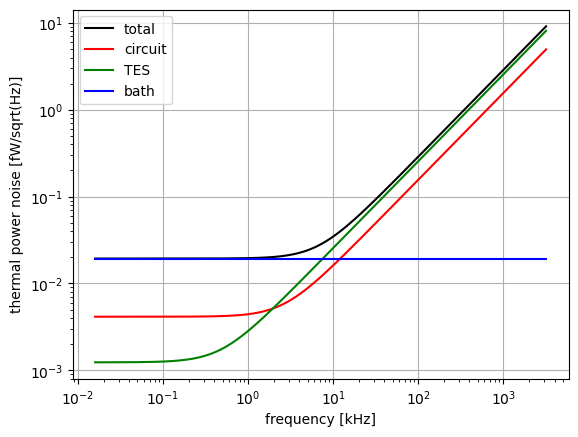

In [24]:
plt.figure()
plt.grid()
plt.xlabel('frequency [kHz]')
plt.ylabel('thermal power noise [fW/sqrt(Hz)]')
#plt.ylim(1e11, 1e17)
#plt.semilogy()
plt.loglog()
plt.plot(1e-3*fn, 1e15*np.sqrt(Sp), 'k', label = 'total')
plt.plot(1e-3*fn, 1e15*np.sqrt(SpRl), 'r', label = 'circuit')
plt.plot(1e-3*fn, 1e15*np.sqrt(SpRtes), 'g', label = 'TES')
plt.plot(1e-3*fn, 1e15*np.sqrt(SpTFN)*np.ones(fn.shape), 'b', label = 'bath')

plt.legend()

In [25]:
SpTFN

3.5742732667722835e-34

In [26]:
# convert to current noise
Ibias = 1e-6 # bias current (A)
Vbias = Ibias*Rs # bias voltage
I0 = Rs*Ibias/R0


# first-order coeff matrix
M = lambda w: np.array([
    [(1j*w + Rl + Rn*(1+beta))/Lsquid, G*Ell/I0/Lsquid],
    [-I0*Rn*(2+beta)/Cw, 1j*w + G*(1-Ell)/Cw]
])

def _getdIdIP(w):
    M_1 = np.linalg.inv(M(w))
    return M_1[0,1]/Cw

def getdIdP2(w):
    return -G*Ell/((1j*w + G*(1-Ell)/Cw)*(1j*w + (Rl + R0*(1+beta))/Lsquid) + Ell*R0*G*(2+beta)/Lsquid/Cw)/Cw/I0/Lsquid

getdIdP = np.vectorize(_getdIdIP, otypes = (np.cdouble,))


dIdP = getdIdP(wspace)
dIdP_n = getdIdP(wn)

dIdP2 = getdIdP2(wspace)
dIdP2_n = getdIdP2(wn)

SITFN = SpTFN*np.abs(dIdP2)**2

# Johnson noise through circuit
SIRl = SpRl*np.abs(dIdP2)**2

# Johnson noise in TES
SIRtes = SpRtes*np.abs(dIdP2)**2

# nominal total
SI = Sp*np.abs(dIdP2)**2
SI_n = Sp_n*np.abs(dIdP2_n)**2

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


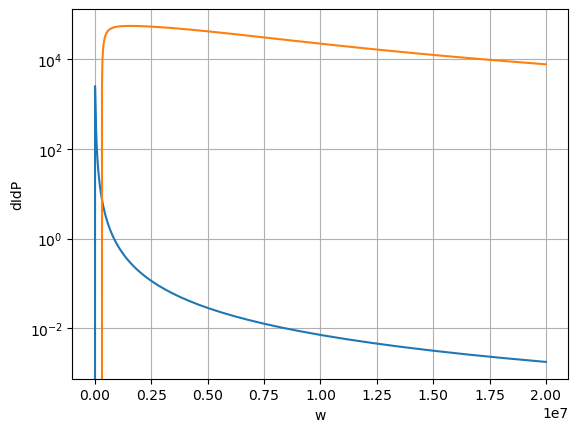

In [27]:
plt.figure()
plt.grid()
plt.xlabel('w')
plt.ylabel('dIdP')
plt.semilogy()
plt.plot(wspace, dIdP)
plt.plot(wspace, dIdP2)

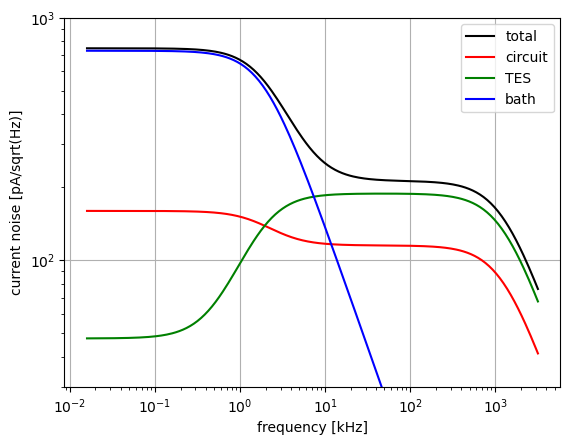

In [28]:
plt.figure()
plt.grid()
plt.xlabel('frequency [kHz]')
plt.ylabel('current noise [pA/sqrt(Hz)]')
#plt.semilogy()
plt.loglog()
plt.ylim(30, 1e3)
plt.plot(1e-3*fn, 1e12*np.sqrt(SI), 'k', label = 'total')
plt.plot(1e-3*fn, 1e12*np.sqrt(SIRl), 'r', label = 'circuit')
plt.plot(1e-3*fn, 1e12*np.sqrt(SIRtes), 'g', label = 'TES')
plt.plot(1e-3*fn, 1e12*np.sqrt(SITFN), 'b', label = 'bath')

plt.legend()

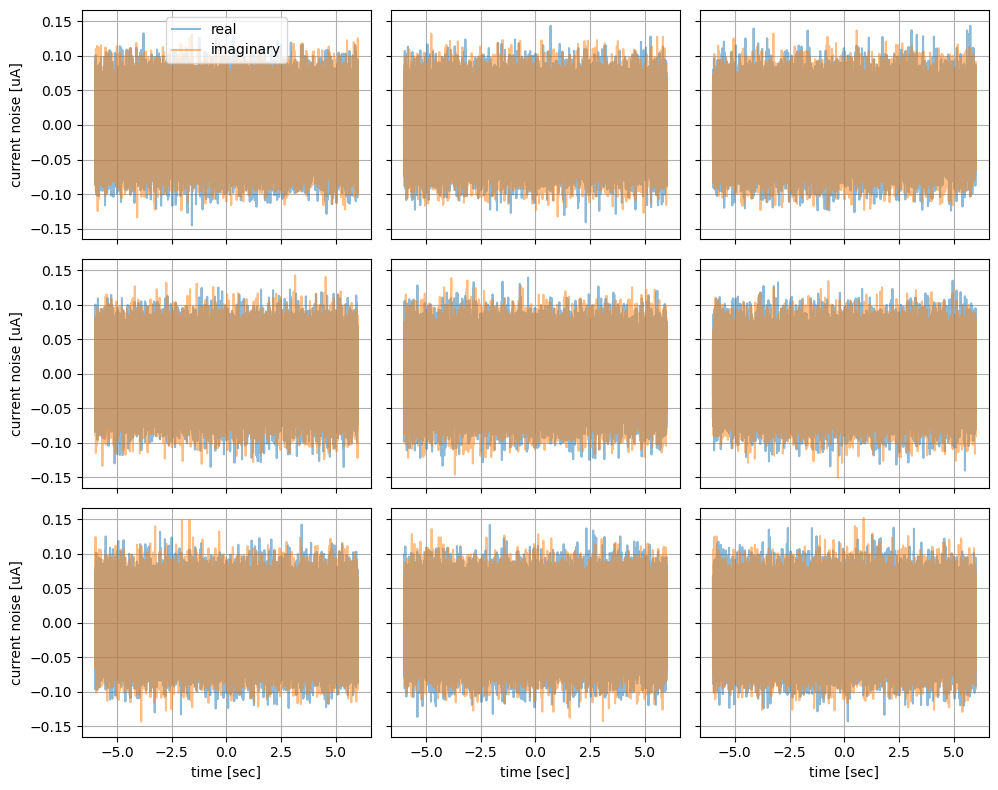

In [29]:
fig,axs = plt.subplots(nrows = 3, ncols = 3, figsize = (10, 8), sharey = True, sharex = True)

for ax in axs.flatten():
    nk = generate_noise(SI_n, T = T)
    
    ax.grid()
    ax.plot(tk, 1e6*np.real(nk), alpha = 0.5, label = 'real')
    ax.plot(tk, 1e6*np.imag(nk), alpha = 0.5, label = 'imaginary')

axs[0,0].legend()

for ax in axs[-1,:]:
    ax.set_xlabel('time [sec]')
for ax in axs[:,0]:
    ax.set_ylabel('current noise [uA]')

fig.tight_layout()